<a href="https://colab.research.google.com/github/mofuoku417/Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Price-Using-Machine-Learning-Techniques/blob/main/MLP_RegressionC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#Calculate the mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
#reading the csv file into pandas data frame
df = pd.read_csv("/content/gdrive/MyDrive/raw_data/df3.csv")
date_rng = pd.date_range(start='2002-02-28', end='2021-03-31', freq='M')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  230 non-null    int64  
 1   Month       230 non-null    object 
 2   cpo_pri     230 non-null    int64  
 3   cno_pri     230 non-null    int64  
 4   sbo_pri     230 non-null    float64
 5   pno_pri     230 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 10.9+ KB


In [7]:
df['Month'] = df['Month'].apply(pd.to_datetime)
df['TimeIndex'] = pd.DataFrame(date_rng, columns=['Month'])

In [8]:
del df['Unnamed: 0']

In [9]:
del df['Month']

In [10]:
df.head()

,cpo_pri,cno_pri,sbo_pri,pno_pri,TimeIndex
0,323,455,468.0,844.0,2002-02-28
1,345,546,485.0,799.0,2002-03-31
2,362,595,466.0,718.0,2002-04-30
3,376,636,442.0,614.0,2002-05-31
4,383,738,429.0,619.0,2002-06-30


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   cpo_pri    230 non-null    int64         
 1   cno_pri    230 non-null    int64         
 2   sbo_pri    230 non-null    float64       
 3   pno_pri    230 non-null    float64       
 4   TimeIndex  230 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 9.1 KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f914944ef10>,
      dtype=object)

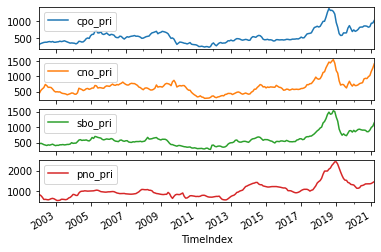

In [12]:
df.set_index('TimeIndex')[['cpo_pri', 'cno_pri','sbo_pri', 'pno_pri']].plot(subplots=True)

In [13]:
df.set_index('TimeIndex')

,cpo_pri,cno_pri,sbo_pri,pno_pri
TimeIndex,,,,
2002-02-28,323,455,468.00,844.00
2002-03-31,345,546,485.00,799.00
2002-04-30,362,595,466.00,718.00
2002-05-31,376,636,442.00,614.00
2002-06-30,383,738,429.00,619.00
...,...,...,...,...
2020-11-30,826,993,860.28,1366.87
2020-12-31,844,1031,910.82,1366.87
2021-01-31,944,1170,997.62,1383.90


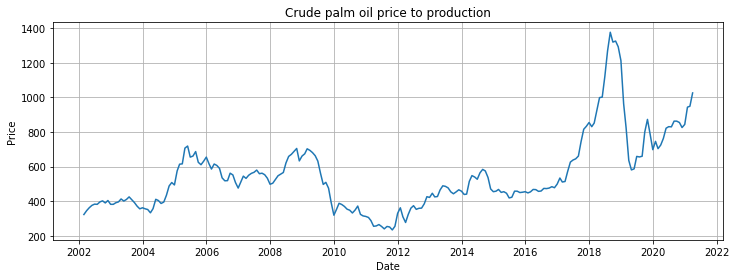

In [14]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot(df.TimeIndex, df.cpo_pri)
plt.title('Crude palm oil price to production')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

In [325]:
230*.8

184.0

In [326]:
230-184

46

In [ ]:
###############################################################################################################################################

In [15]:
split_date = '2017-06'
df_training = df.loc[df.TimeIndex <= split_date]
df_test = df.loc[df.TimeIndex > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

184 days of training data 
 46 days of testing data 


In [16]:
df_test['cpo_pri'].head()

184    638
185    645
186    661
187    743
188    816
Name: cpo_pri, dtype: int64

In [17]:
df_training.cpo_pri.head()

0    323
1    345
2    362
3    376
4    383
Name: cpo_pri, dtype: int64

In [18]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [19]:
df.set_index('TimeIndex')

,cpo_pri,cno_pri,sbo_pri,pno_pri
TimeIndex,,,,
2002-02-28,323,455,468.00,844.00
2002-03-31,345,546,485.00,799.00
2002-04-30,362,595,466.00,718.00
2002-05-31,376,636,442.00,614.00
2002-06-30,383,738,429.00,619.00
...,...,...,...,...
2020-11-30,826,993,860.28,1366.87
2020-12-31,844,1031,910.82,1366.87
2021-01-31,944,1170,997.62,1383.90


In [ ]:
#################################################################################################################################################

In [248]:
X_train_df, y_train = create_time_features(
    df_training, target='cpo_pri')
X_test_df, y_test = create_time_features(df_test, target='cpo_pri')
scaler = MinMaxScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



TypeError: ignored

In [46]:
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [249]:
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index): (len(train_index)+len(test_index))].values.ravel()

NameError: ignored

In [25]:
from sklearn.svm import SVR
from sklearn import linear_model, svm

In [26]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
svr_pred = reg.predict(X_test)

In [27]:
svr_pred

array([650.60053402, 675.76483903, 704.58581755, 710.34018683,
       719.85110095, 741.68223038, 753.95489301, 777.15574981,
       769.72404803, 778.13773528, 774.02659342, 751.94753325,
       751.60194901, 729.88513671, 706.53272881, 703.59268084,
       718.15837876, 725.21037087, 672.02144159, 623.67954257,
       601.82274332, 630.72328349, 601.44513647, 582.71985354,
       650.57908152, 703.62212621, 690.2745671 , 656.13313549,
       695.29374607, 672.04231226, 695.20298322, 716.27048068,
       726.08234073, 717.24811438, 714.08734911, 731.72232106,
       727.40993867, 706.12707412, 712.4499624 , 734.11060397,
       776.32891818, 790.42142673, 808.95941619])

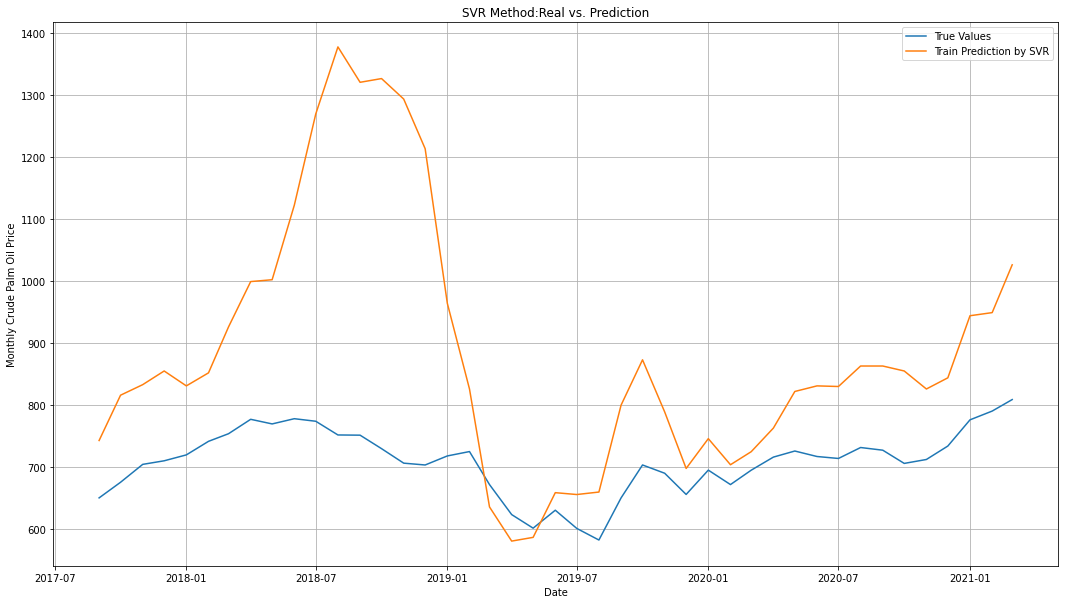

In [28]:
plt.figure(figsize=(18,10))
plt.grid()
plt.plot(y_test.index, svr_pred, label = 'Train')
plt.plot(y_test,  label = 'Test')
plt.plot(svr_pred = 'mlp forecast')
plt.legend(['True Values', 'Train Prediction by SVR', 'Test Prediction by SVR'],loc='best')
plt.title('SVR Method:Real vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

In [30]:
greg = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
greg.fit(X_train, y_train)
gsvr_pred = greg.predict(X_test)

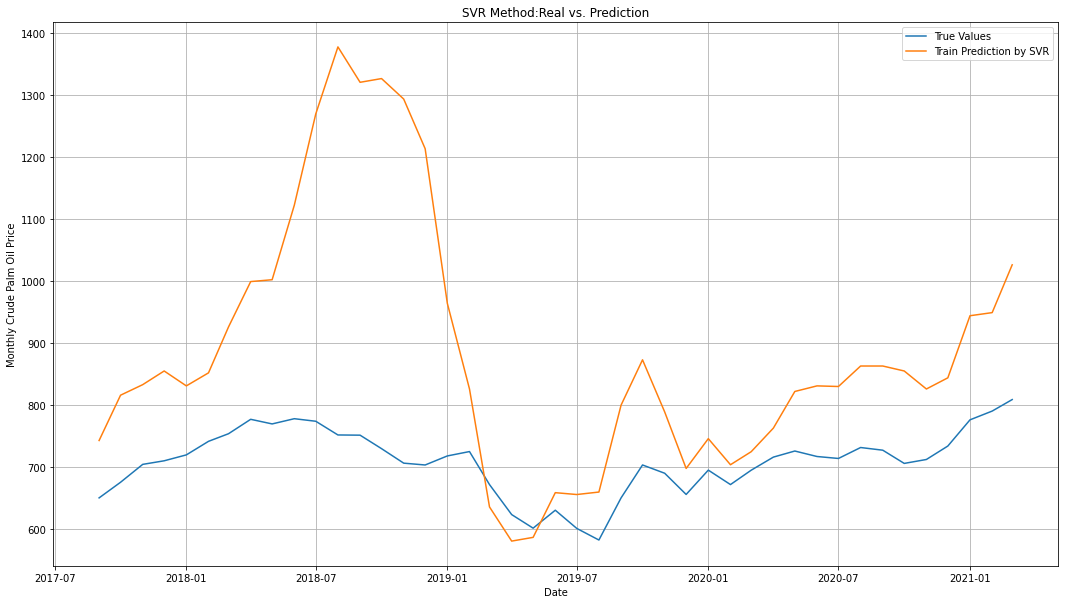

In [31]:
plt.figure(figsize=(18,10))
plt.grid()
plt.plot(y_test.index, svr_pred, label = 'Train')
plt.plot(y_test,  label = 'Test')
plt.plot(gsvr_pred = 'mlp forecast')
plt.legend(['True Values', 'Train Prediction by SVR', 'Test Prediction by SVR'],loc='best')
plt.title('SVR Method:Real vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

In [ ]:
############################################################################################################################################

In [342]:
df_train = df.iloc[0:184]
df_test = df.iloc[184:]

In [84]:
df_train

NameError: ignored

In [20]:
df_test

,cpo_pri,cno_pri,sbo_pri,pno_pri,TimeIndex
184,638,731,697.33,1071.64,2017-06-30
185,645,763,715.04,1016.33,2017-07-31
186,661,769,719.03,1055.21,2017-08-31
187,743,828,753.70,1078.17,2017-09-30
188,816,894,788.70,1169.41,2017-10-31
189,833,979,835.55,1268.18,2017-11-30
190,855,929,887.12,1404.95,2017-12-31
191,831,910,921.79,1472.30,2018-01-31
192,852,930,977.48,1523.39,2018-02-28
193,926,1010,1007.69,1633.34,2018-03-31


In [335]:
df.cpo_pri

0       323
1       345
2       362
3       376
4       383
       ... 
225     826
226     844
227     944
228     949
229    1026
Name: cpo_pri, Length: 230, dtype: int64

In [21]:
x = df[['cno_pri', 'sbo_pri', 'pno_pri']]
y = df[['cpo_pri']]

In [16]:
#y = np.reshape(y, (-1,1))

In [22]:
scaler_x = MinMaxScaler()   
scaler_y = MinMaxScaler()
print(scaler_x.fit(x))       
xscale=scaler_x.transform(x)
print(scaler_y.fit(y))               
yscale=scaler_y.transform(y)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [23]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2, random_state=0)

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [26]:
df_training.head()

,cpo_pri,cno_pri,sbo_pri,pno_pri,TimeIndex
0,323,455,468.0,844.0,2002-02-28
1,345,546,485.0,799.0,2002-03-31
2,362,595,466.0,718.0,2002-04-30
3,376,636,442.0,614.0,2002-05-31
4,383,738,429.0,619.0,2002-06-30


In [27]:
df_test.head()

,cpo_pri,cno_pri,sbo_pri,pno_pri,TimeIndex
184,638,731,697.33,1071.64,2017-06-30
185,645,763,715.04,1016.33,2017-07-31
186,661,769,719.03,1055.21,2017-08-31
187,743,828,753.70,1078.17,2017-09-30
188,816,894,788.70,1169.41,2017-10-31


In [353]:
X_train

array([[0.25513428, 0.227603  , 0.24233586],
       [0.22274882, 0.20597307, 0.28469102],
       [0.30331754, 0.25490479, 0.36731576],
       [0.45102686, 0.52523893, 0.83500788],
       [0.09083728, 0.04198611, 0.11238594],
       [0.28199052, 0.31659016, 0.46697906],
       [0.78988942, 0.79574932, 0.76247869],
       [0.21563981, 0.27086287, 0.26431765],
       [0.12559242, 0.12586219, 0.03163234],
       [0.15560821, 0.24364921, 0.2090951 ],
       [0.06477093, 0.02394514, 0.11130829],
       [0.28515008, 0.16730355, 0.36060327],
       [0.30647709, 0.36911085, 0.52608327],
       [0.13823065, 0.17472983, 0.11312581],
       [0.2385466 , 0.23370745, 0.304035  ],
       [0.27014218, 0.25456031, 0.36060327],
       [0.30252765, 0.25964735, 0.21606494],
       [0.2614534 , 0.31171942, 0.2830826 ],
       [0.35781991, 0.11384556, 0.03056005],
       [0.15481833, 0.04092063, 0.12420249],
       [0.34518167, 0.19315533, 0.16727608],
       [0.06793049, 0.0336706 , 0.10313214],
       [0.

In [354]:
len(y_test)

46

In [355]:
df_test['cpo_pri']

184     638
185     645
186     661
187     743
188     816
189     833
190     855
191     831
192     852
193     926
194     999
195    1002
196    1122
197    1269
198    1377
199    1320
200    1326
201    1293
202    1213
203     964
204     826
205     636
206     581
207     587
208     659
209     656
210     660
211     800
212     873
213     789
214     698
215     746
216     704
217     725
218     763
219     822
220     831
221     830
222     863
223     863
224     855
225     826
226     844
227     944
228     949
229    1026
Name: cpo_pri, dtype: int64

In [28]:
len(df_test['cpo_pri'])

46

In [74]:
230-184

46

In [29]:
pipe_MLPRegressor = Pipeline([('scaler',  MinMaxScaler()),
            ('MLPRegressor', MLPRegressor(random_state = 42))])

In [30]:
grid_params_MLPRegressor = [{
    'MLPRegressor__solver': ['sgd', 'adam'],
    'MLPRegressor__alpha': [0.0001, 0.05],
    'MLPRegressor__max_iter': [100,200,300, 500, 1000],
    'MLPRegressor__activation' : ['relu','logistic','tanh'],
    'MLPRegressor__learning_rate' : ['constant', 'adaptive'],
    'MLPRegressor__hidden_layer_sizes':[(50,50,50), (50,100,50), (100,)],}]


CV_mlpregressor_grid = GridSearchCV (estimator = pipe_MLPRegressor,
                               param_grid = grid_params_MLPRegressor, n_jobs=-1,
                               cv = 5,return_train_score=True, verbose=0)


CV_mlpregressor_grid.fit(X_train, y_train)

ypred=CV_mlpregressor_grid.predict(X_test)

print (np.c_[y_test, ypred])

#print (np.c_[y_test, ypred])
print('Train Accuracy : %.3f'%CV_mlpregressor_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%CV_mlpregressor_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%CV_mlpregressor_grid.best_score_)
print('Best Parameters : ',CV_mlpregressor_grid.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[0.18285214 0.16706424]
 [0.92650919 0.96308364]
 [0.07786527 0.071098  ]
 [0.3735783  0.37828687]
 [0.20297463 0.18806102]
 [0.13473316 0.19387831]
 [0.4295713  0.43830963]
 [0.29046369 0.26559903]
 [0.52143482 0.47101078]
 [0.20384952 0.23117992]
 [0.24584427 0.23222372]
 [0.02712161 0.05141235]
 [0.29133858 0.28001992]
 [0.13648294 0.17330945]
 [0.167979   0.12447179]
 [0.19247594 0.16435065]
 [0.08573928 0.12645769]
 [0.12948381 0.17589809]
 [0.32983377 0.25956117]
 [0.18547682 0.26126671]
 [0.23184602 0.26585735]
 [0.04724409 0.04835914]
 [0.37182852 0.39875221]
 [0.55905512 0.47422448]
 [0.0183727  0.05022551]
 [0.28608924 0.27286609]
 [0.20734908 0.27792768]
 [0.33420822 0.28751023]
 [0.13735783 0.12341991]
 [0.17935258 0.16556883]
 [0.24234471 0.26477407]
 [0.22047244 0.18790714]
 [0.54330709 0.50254161]
 [0.28696413 0.30102899]
 [0.21084864 0.25063656]
 [0.15223097 0.11113756]
 [0.14610674 0.12004486]
 [0.24496938 0.27814347]
 [0.14698163 0.16658682]
 [0.12860892 0.18438992]


In [31]:
model = Sequential()
model.add(Dense(12, input_dim=3, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                48        
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [33]:
history = model.fit(X_train, y_train, epochs=250, batch_size=50,  verbose=1, validation_split=0.2)

Epoch 1/250
3/3 [==============================] - 1s 99ms/step - loss: 0.1082 - mse: 0.1082 - mae: 0.2687 - val_loss: 0.1346 - val_mse: 0.1346 - val_mae: 0.3149
Epoch 2/250
3/3 [==============================] - 0s 15ms/step - loss: 0.0999 - mse: 0.0999 - mae: 0.2548 - val_loss: 0.1252 - val_mse: 0.1252 - val_mae: 0.3012
Epoch 3/250
3/3 [==============================] - 0s 14ms/step - loss: 0.0922 - mse: 0.0922 - mae: 0.2420 - val_loss: 0.1168 - val_mse: 0.1168 - val_mae: 0.2891
Epoch 4/250
3/3 [==============================] - 0s 12ms/step - loss: 0.0858 - mse: 0.0858 - mae: 0.2305 - val_loss: 0.1093 - val_mse: 0.1093 - val_mae: 0.2781
Epoch 5/250
3/3 [==============================] - 0s 17ms/step - loss: 0.0801 - mse: 0.0801 - mae: 0.2197 - val_loss: 0.1027 - val_mse: 0.1027 - val_mae: 0.2679
Epoch 6/250
3/3 [==============================] - 0s 13ms/step - loss: 0.0750 - mse: 0.0750 - mae: 0.2099 - val_loss: 0.0966 - val_mse: 0.0966 - val_mae: 0.2581
Epoch 7/250
3/3 [===========

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


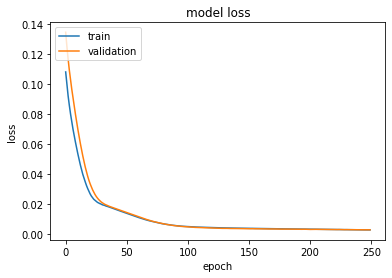

In [34]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [35]:
ypred = model.predict(X_test)

In [364]:
len(ypred)

46

In [365]:
len(df_test.TimeIndex)

46

In [366]:
len(df_training.TimeIndex)

184

In [367]:
len(df_training.cpo_pri)

184

In [368]:
len(df_test.TimeIndex)

46

In [369]:
len(ypred)

46

In [316]:
df_test

,cpo_pri,cno_pri,sbo_pri,pno_pri,TimeIndex
183,626,732,698.12,1102.31,2017-05-31
184,638,731,697.33,1071.64,2017-06-30
185,645,763,715.04,1016.33,2017-07-31
186,661,769,719.03,1055.21,2017-08-31
187,743,828,753.70,1078.17,2017-09-30
188,816,894,788.70,1169.41,2017-10-31
189,833,979,835.55,1268.18,2017-11-30
190,855,929,887.12,1404.95,2017-12-31
191,831,910,921.79,1472.30,2018-01-31
192,852,930,977.48,1523.39,2018-02-28


In [36]:
mlp_pred = scaler_y.inverse_transform(ypred)

In [37]:
mlp_pred

array([[ 418.77362],
       [1363.503  ],
       [ 326.10913],
       [ 645.5922 ],
       [ 439.56934],
       [ 451.8416 ],
       [ 715.7161 ],
       [ 519.0494 ],
       [ 759.3859 ],
       [ 482.65518],
       [ 472.43198],
       [ 303.57324],
       [ 543.64417],
       [ 440.37805],
       [ 376.06845],
       [ 416.90414],
       [ 385.48157],
       [ 452.2291 ],
       [ 516.4453 ],
       [ 506.58057],
       [ 522.6053 ],
       [ 298.18866],
       [ 668.2274 ],
       [ 765.1081 ],
       [ 300.83206],
       [ 536.1856 ],
       [ 524.4526 ],
       [ 544.1835 ],
       [ 376.31085],
       [ 424.65024],
       [ 517.2284 ],
       [ 437.86548],
       [ 796.24365],
       [ 565.33435],
       [ 524.09454],
       [ 362.50232],
       [ 372.26297],
       [ 530.726  ],
       [ 436.37622],
       [ 438.11566],
       [ 680.43567],
       [ 505.83844],
       [ 494.00943],
       [ 446.45154],
       [ 592.493  ],
       [1119.7979 ]], dtype=float32)

In [38]:
MLP_predictions = pd.DataFrame(mlp_pred, columns = ['MLP_predictions'])

In [39]:
MLP_predictions

,MLP_predictions
0,418.773621
1,1363.503052
2,326.109131
3,645.592224
4,439.569336
5,451.841614
6,715.716125
7,519.049377
8,759.385925
9,482.655182


In [40]:
testY = scaler_y.inverse_transform(y_test)

In [41]:
testY

array([[ 443.],
       [1293.],
       [ 323.],
       [ 661.],
       [ 466.],
       [ 388.],
       [ 725.],
       [ 566.],
       [ 830.],
       [ 467.],
       [ 515.],
       [ 265.],
       [ 567.],
       [ 390.],
       [ 426.],
       [ 454.],
       [ 332.],
       [ 382.],
       [ 611.],
       [ 446.],
       [ 499.],
       [ 288.],
       [ 659.],
       [ 873.],
       [ 255.],
       [ 561.],
       [ 471.],
       [ 616.],
       [ 391.],
       [ 439.],
       [ 511.],
       [ 486.],
       [ 855.],
       [ 562.],
       [ 475.],
       [ 408.],
       [ 401.],
       [ 514.],
       [ 402.],
       [ 381.],
       [ 581.],
       [ 561.],
       [ 548.],
       [ 465.],
       [ 660.],
       [ 964.]])

In [42]:
testY2 = pd.DataFrame(testY, columns = ['testY'])

In [43]:
testY2

,testY
0,443.0
1,1293.0
2,323.0
3,661.0
4,466.0
5,388.0
6,725.0
7,566.0
8,830.0
9,467.0


In [73]:
ActPred = pd.DataFrame(np.concatenate([testY, mlp_pred], axis=1), columns= ['Actual','Predicted'])

In [74]:
ActPred 

,Actual,Predicted
0,443.0,418.773621
1,1293.0,1363.503052
2,323.0,326.109131
3,661.0,645.592224
4,466.0,439.569336
5,388.0,451.841614
6,725.0,715.716125
7,566.0,519.049377
8,830.0,759.385925
9,467.0,482.655182


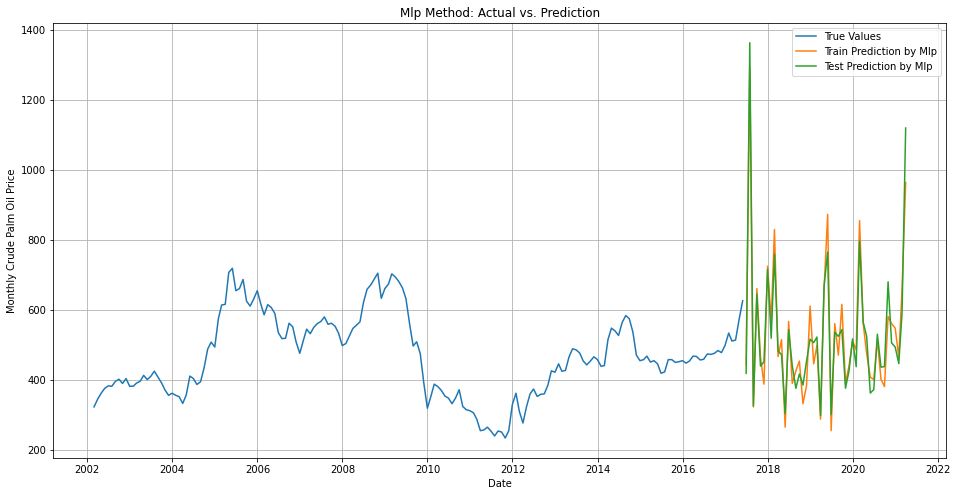

In [75]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_training.TimeIndex, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.TimeIndex, testY2,  label = 'Test')
plt.plot(df_test.TimeIndex, MLP_predictions,label = 'MLP Prediction')
plt.legend(['True Values', 'Train Prediction by Mlp', 'Test Prediction by Mlp'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

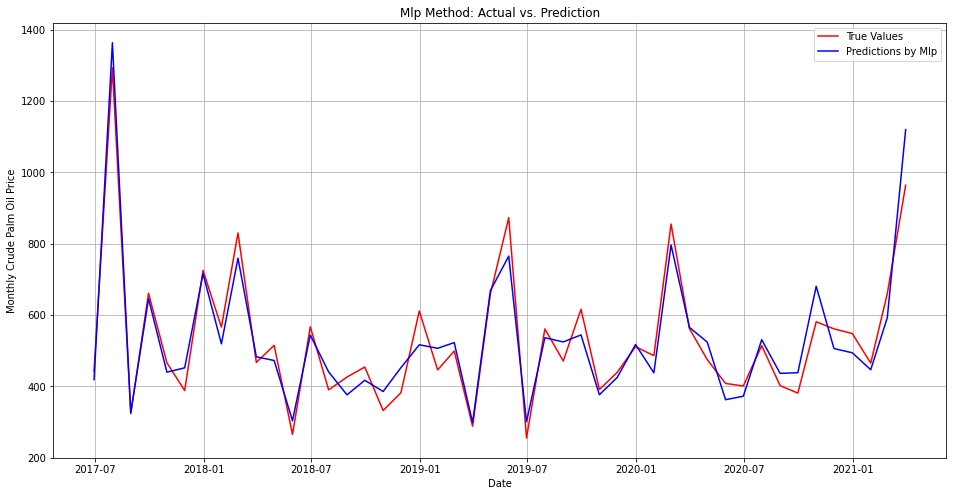

In [86]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.TimeIndex, testY2, color = 'red',  label = 'Test')
plt.plot(df_test.TimeIndex,  MLP_predictions, color = 'blue',label = 'MLP Prediction')
plt.legend(['True Values', 'Predictions by Mlp', 'MLP Prediction'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

In [92]:
MAE_mlp = mean_absolute_error(testY2, MLP_predictions)
print('MAE value of the MLP Model is:', MAE_mlp)

#mda(testY2, MLP_predictions)

#MDA_mlp = np.mean((np.sign(testY2[1:] - testY2[:-1]) == np.sign(MLP_predictions[1:] - MLP_predictions[:-1])).astype(int))
#print('MDA value of the MLP Model is:', (MDA_mlp))

MAPE_mlp = mean_absolute_percentage_error(testY2, MLP_predictions)
print('MAPE value of the MLP Model is:', (MAPE_mlp))

RMSE_mlp = mean_squared_error(testY2, MLP_predictions, squared=False)
print('RMSE value of the MLP Model is:', (RMSE_mlp))

MSE_mlp = mean_squared_error(testY2, MLP_predictions)
print('MSE value of the MLP Model is:', (MSE_mlp))

MAE value of the MLP Model is: 44.3713146707286
MAPE value of the MLP Model is: 8.625042333088063
RMSE value of the MLP Model is: 53.80412557919221
MSE value of the MLP Model is: 2894.8839293414853
